# Introduction 📝
🎯 **Goal:** To build algorithms to rate the complexity of reading passages for grade 3-12 classroom use. 

📖 **Data:** 
> **train.csv / test.csv** - the training and testing set
> - ```id``` - unique ID for excerpt
> - ```url_legal``` - URL of source 
> - ```license``` - license of source material 
> - ```excerpt``` - text to predict reading ease of
> - ```target``` - reading ease
> - ```standard_error``` - measure of spread of scores among multiple raters for each excerpt

📌 **Note:** ```url_legal```, ```license``` and ```standard error``` are blank in the test set.

# Import libraries 📚

In [1]:

#!pip install textstat
#!pip install nlpaug
#!pip install torch>=1.6.0 transformers>=4.0.0
#!pip install torch>=1.6.0 fairseq>=0.9.0 sacremoses>=0.0.43 fastBPE>=0.1.0
#!pip install nltk>=3.4.5

import sys

sys.path.append('../input/nlpaug')
import nlpaug
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import re
import nltk
sys.path.append('..input/textstat')
#import textstat
import time
import wandb
import xgboost as xgb


from pandas import DataFrame
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from nltk import pos_tag, pos_tag_sents
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import CountVectorizer as CV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error as mse

from nltk import tokenize
from nltk.corpus import wordnet, stopwords
from nltk.stem import WordNetLemmatizer



import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

import os
os.environ["MODEL_DIR"] = '../model'


from scipy.stats import gaussian_kde

#nltk.download('stopwords')

In [2]:
'''
from nlpaug.util.file.download import DownloadUtil
DownloadUtil.download_word2vec(dest_dir='.') # Download word2vec model
DownloadUtil.download_glove(model_name='glove.6B', dest_dir='.') # Download GloVe model
DownloadUtil.download_fasttext(model_name='wiki-news-300d-1M', dest_dir='.') # Download fasttext model
'''

"\nfrom nlpaug.util.file.download import DownloadUtil\nDownloadUtil.download_word2vec(dest_dir='.') # Download word2vec model\nDownloadUtil.download_glove(model_name='glove.6B', dest_dir='.') # Download GloVe model\nDownloadUtil.download_fasttext(model_name='wiki-news-300d-1M', dest_dir='.') # Download fasttext model\n"

# Data loading and cleaning

In [3]:
train_df = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
test_df = pd.read_csv("../input/commonlitreadabilityprize/test.csv")

train_df.drop(columns = ['url_legal','license','id'], inplace = True)
train_df = train_df[train_df['standard_error'] != 0.].reset_index()
train_df.drop(columns = ['index'], inplace = True)

# Data augmentation

In [4]:
'''
max = 3
for text, idx in zip([train_df['excerpt'][i] for i in range(0,max)],range(0,max)):
    print(text)
    start = time.time()
    aug_text = aug.augment(text,num_thread = 1000)
    end = time.time()
    print('\n'+aug_text)
    print(str(idx) + ' ' + str(end-start))
 '''   
#bert-base-uncased:  circa 5.9 s
#distilbert-base-uncased:   circa 3.8 s
#roberta:     circa 7.2 s

"\nmax = 3\nfor text, idx in zip([train_df['excerpt'][i] for i in range(0,max)],range(0,max)):\n    print(text)\n    start = time.time()\n    aug_text = aug.augment(text,num_thread = 1000)\n    end = time.time()\n    print('\n'+aug_text)\n    print(str(idx) + ' ' + str(end-start))\n "

In [5]:
#aug = naw.ContextualWordEmbsAug(model_path='roberta-base', action="substitute")
aug = naw.SynonymAug(aug_src='wordnet',aug_min = 100)

df_train_aug = pd.DataFrame()

df_train_aug['excerpt'] = [aug.augment(train_df['excerpt'][i], num_thread = 2) for i in range(0, 100)]
df_train_aug['target'] = [np.random.normal(train_df['target'][i],train_df['standard_error'][i]*0.2) for i in range(0,100)]
df_train_aug['standard_error'] = train_df['standard_error']

#df_train_aug['target'] = []



In [6]:
train_df = train_df.append(df_train_aug, ignore_index = True)

In [7]:
train_df.head(-10)

excerpt    target  \
0     When the young people returned to the ballroom... -0.340259   
1     All through dinner time, Mrs. Fayre was somewh... -0.315372   
2     As Roger had predicted, the snow departed as q... -0.580118   
3     And outside before the palace a great garden w... -1.054013   
4     Once upon a time there were Three Bears who li...  0.247197   
...                                                 ...       ...   
2918  The house stand rattling high, and from that w... -0.522169   
2919  Goop embody even a plebe in the Naval Honorary... -0.528738   
2920  This sentence atomic number 2 had to carry fis... -1.345593   
2921  Prison term is a very leftover sort of affair,... -1.223809   
2922  Vegetation Henry lee ' s natal day add up in J... -0.087999   

      standard_error  
0           0.464009  
1           0.480805  
2           0.476676  
3           0.450007  
4           0.510845  
...              ...  
2918        0.463225  
2919        0.491325  
2920        0.500264  
2921        0.468613  
2922        0.459439  

[2923 rows x 3 columns]

In [8]:
df_train_aug.to_csv('augmented_data_wordnet.csv')

# Statistical feature extraction

In [9]:
#train_df = pd.read_csv("../input/commonlitreadabilityprize/train.csv")

stopwords_en = set(stopwords.words('english'))
lemma = nltk.WordNetLemmatizer()

def tokenize(text):
    text = re.sub(r'[^a-z]', ' ', text.lower())
    words = nltk.word_tokenize(text)
    words = [lemma.lemmatize(w) for w in words if not w in stopwords_en]
    return words
def normalize(text):
    return ' '.join(tokenize(text))
def word_count(text):
    return len(text.split(' '))
def long_words(text, length):
    return len([w for w in text.split(' ') if len(w) >= length])
def max_word_len(text):
    words = (re.sub(r"[,.;@#?!&$]+\ *-", " ", text)).split()
    return np.max([len(w) for w in text.split(' ')])
def avg_sen_len(text):
    text.replace('...','.')
    sen_lens = []
    for sentence in text.split('.'):
        sen_lens.append(len(sentence.split())) 
    return sum(sen_lens)/len(sen_lens)
def avg_word_len(text):
    words = (re.sub(r"[,.;@#?!&$]+\ *-", " ", text)).split()
    return sum([len(word) for word in words])/len(words)
def punct_count(text):
    return sum(text.count(x) for x in "[,.;:@#?!&$]+\ *-")
def min_sen_len(text):
    text.replace('...','.')
    text.replace('..','.')
    sen_lens = []
    for sentence in text.split('.'):
        sen_lens.append(len(sentence.split())) 
    return np.min(sen_lens)
def max_sen_len(text):
    text.replace('...','.')
    text.replace('..','.')
    sen_lens = []
    for sentence in text.split('.'):
        sen_lens.append(len(sentence.split())) 
    return np.max(sen_lens)
    

def extract_statistical_feature(dataframe):
    dataframe['tokens'] = [np.array(tokenize(str(dataframe['excerpt'][i]))) for i in range(0, dataframe['excerpt'].size)]
    dataframe['normalized'] = [normalize(str(dataframe['excerpt'][i])) for i in range(0, dataframe['excerpt'].size)]
    dataframe['count'] = dataframe['excerpt'].apply(word_count)
    dataframe['len'] = dataframe['excerpt'].apply(len)
    dataframe['word7'] = dataframe['excerpt'].apply(lambda t: long_words(t, 7))
    dataframe['word10'] = dataframe['excerpt'].apply(lambda t: long_words(t, 10))
    dataframe['word13'] = dataframe['excerpt'].apply(lambda t: long_words(t, 13))
    dataframe['max_word_len'] = [max_word_len(dataframe['excerpt'][i]) for i in range(0,dataframe['excerpt'].size)]

    #dataframe['sentence_num'] = textstat.sentence_count(dataframe['excerpt'])
    #textstat.sentence_count(dataframe['excerpt'])
    #dataframe['sentence_num'] = dataframe.apply(lambda row: textstat.sentence_count(row.excerpt))
    dataframe['punct_count'] = [punct_count(dataframe['excerpt'][i]) for i in range(0, dataframe['excerpt'].size)]
    #dataframe['sentence_count'] = [textstat.sentence_count(dataframe['excerpt'][i]) for i in range(0,dataframe['excerpt'].size)]
    dataframe['avg_sen_len'] = [avg_sen_len(dataframe['excerpt'][i]) for i in range(0,dataframe['excerpt'].size)]
    dataframe['min_sen_len'] = [min_sen_len(dataframe['excerpt'][i]) for i in range(0,dataframe['excerpt'].size)]
    dataframe['max_sen_len'] = [max_sen_len(dataframe['excerpt'][i]) for i in range(0,dataframe['excerpt'].size)]
    dataframe['avg_word_len'] = [avg_word_len(dataframe['excerpt'][i]) for i in range(0,dataframe['excerpt'].size)]
    #dataframe['syllabe_num'] = [textstat.syllable_count(dataframe['excerpt'][i]) for i in range(0,dataframe['excerpt'].size)]
    #dataframe['lexicon_count'] = [textstat.lexicon_count(dataframe['excerpt'][i]) for i in range(0,dataframe['excerpt'].size)]
    #dataframe['lexicon_num_with_punc'] = [textstat.lexicon_count(dataframe['excerpt'][i], removepunct = False) for i in range(0,dataframe['excerpt'].size)]
    #dataframe['difficult_words'] = [textstat.difficult_words(dataframe['excerpt'][i]) for i in range(0,dataframe['excerpt'].size)]

    #dataframe['flesch_ease_score'] = [textstat.flesch_reading_ease(dataframe['excerpt'][i]) for i in range(0,dataframe['excerpt'].size)]
    #dataframe['textstat_auto_score] = [textstat.automated_readability_index(dataframe['excerpt'][i]) for i in range(0,dataframe['excerpt'].size)]
    #dataframe['textstat_consensus'] = [textstat.text_standard(dataframe['excerpt'][i]) for i in range(0,dataframe['excerpt'].size)]
    



In [10]:
extract_statistical_feature(train_df)
train_df['rounded_target'] = [np.round(train_df['target'][i]) for i in range(0,train_df['excerpt'].size)]

In [11]:
training_vars = ['count','len','word7','word10','word13',
                 'avg_sen_len','avg_word_len','punct_count','max_sen_len','max_word_len']

In [12]:
train_df.describe()
#train_df['target'].size
#loc = train_df[train_df['standard_error'] == 0.].index   #removes the outlier with readibility 0 and std error 0
#print(loc)
#train_df.drop(loc, inplace = True)


target  standard_error        count          len        word7  \
count  2933.000000     2933.000000  2933.000000  2933.000000  2933.000000   
mean     -0.952244        0.491369   172.543471   976.428571    36.537334   
std       1.026095        0.033299    17.689413   119.352880    12.647589   
min      -3.676268        0.428233   125.000000   669.000000     0.000000   
25%      -1.680656        0.468447   159.000000   889.000000    27.000000   
50%      -0.900441        0.484590   174.000000   976.000000    35.000000   
75%      -0.203188        0.505781   187.000000  1063.000000    45.000000   
max       1.711390        0.649671   237.000000  1341.000000    88.000000   

            word10       word13  max_word_len  punct_count  avg_sen_len  \
count  2933.000000  2933.000000   2933.000000  2933.000000  2933.000000   
mean      9.523355     1.801227     14.288783   195.400273    19.782073   
std       5.960238     1.882199      2.971350    20.518169     7.259249   
min       0.000000     0.000000      6.000000   148.000000     5.285714   
25%       5.000000     0.000000     12.000000   180.000000    15.000000   
50%       9.000000     1.000000     14.000000   196.000000    18.888889   
75%      13.000000     3.000000     16.000000   212.000000    23.428571   
max      45.000000    19.000000     42.000000   275.000000    64.333333   

       min_sen_len  max_sen_len  avg_word_len  rounded_target  
count  2933.000000  2933.000000   2933.000000     2933.000000  
mean      0.445278    41.735424      4.624590       -0.962496  
std       1.973431    17.126950      0.424970        1.060881  
min       0.000000    10.000000      3.257895       -4.000000  
25%       0.000000    30.000000      4.325000       -2.000000  
50%       0.000000    38.000000      4.580838       -1.000000  
75%       0.000000    49.000000      4.872832       -0.000000  
max      31.000000   155.000000      7.090323        2.000000

In [13]:
train_df.head()

excerpt    target  \
0  When the young people returned to the ballroom... -0.340259   
1  All through dinner time, Mrs. Fayre was somewh... -0.315372   
2  As Roger had predicted, the snow departed as q... -0.580118   
3  And outside before the palace a great garden w... -1.054013   
4  Once upon a time there were Three Bears who li...  0.247197   

   standard_error                                             tokens  \
0        0.464009  [young, people, returned, ballroom, presented,...   
1        0.480805  [dinner, time, mr, fayre, somewhat, silent, ey...   
2        0.476676  [roger, predicted, snow, departed, quickly, ca...   
3        0.450007  [outside, palace, great, garden, walled, round...   
4        0.510845  [upon, time, three, bear, lived, together, hou...   

                                          normalized  count  len  word7  \
0  young people returned ballroom presented decid...    174  992     39   
1  dinner time mr fayre somewhat silent eye resti...    164  937     33   
2  roger predicted snow departed quickly came two...    162  908     34   
3  outside palace great garden walled round fille...    163  909     30   
4  upon time three bear lived together house wood...    147  723     10   

   word10  word13  max_word_len  punct_count  avg_sen_len  min_sen_len  \
0       9       1            14          200    14.916667            0   
1       9       2            15          204    15.545455            0   
2       8       3            14          194    14.083333            1   
3       5       1            13          195    27.333333            0   
4       4       0            12          178    24.500000            0   

   max_sen_len  avg_word_len  rounded_target  
0           30      4.547486            -0.0  
1           28      4.550296            -0.0  
2           31      4.475904            -1.0  
3           58      4.548780            -1.0  
4           35      3.925170             0.0

In [14]:
train_df.describe()

target  standard_error        count          len        word7  \
count  2933.000000     2933.000000  2933.000000  2933.000000  2933.000000   
mean     -0.952244        0.491369   172.543471   976.428571    36.537334   
std       1.026095        0.033299    17.689413   119.352880    12.647589   
min      -3.676268        0.428233   125.000000   669.000000     0.000000   
25%      -1.680656        0.468447   159.000000   889.000000    27.000000   
50%      -0.900441        0.484590   174.000000   976.000000    35.000000   
75%      -0.203188        0.505781   187.000000  1063.000000    45.000000   
max       1.711390        0.649671   237.000000  1341.000000    88.000000   

            word10       word13  max_word_len  punct_count  avg_sen_len  \
count  2933.000000  2933.000000   2933.000000  2933.000000  2933.000000   
mean      9.523355     1.801227     14.288783   195.400273    19.782073   
std       5.960238     1.882199      2.971350    20.518169     7.259249   
min       0.000000     0.000000      6.000000   148.000000     5.285714   
25%       5.000000     0.000000     12.000000   180.000000    15.000000   
50%       9.000000     1.000000     14.000000   196.000000    18.888889   
75%      13.000000     3.000000     16.000000   212.000000    23.428571   
max      45.000000    19.000000     42.000000   275.000000    64.333333   

       min_sen_len  max_sen_len  avg_word_len  rounded_target  
count  2933.000000  2933.000000   2933.000000     2933.000000  
mean      0.445278    41.735424      4.624590       -0.962496  
std       1.973431    17.126950      0.424970        1.060881  
min       0.000000    10.000000      3.257895       -4.000000  
25%       0.000000    30.000000      4.325000       -2.000000  
50%       0.000000    38.000000      4.580838       -1.000000  
75%       0.000000    49.000000      4.872832       -0.000000  
max      31.000000   155.000000      7.090323        2.000000

In [15]:
print(train_df['excerpt'][0])
print(train_df['target'][0])
print(train_df['standard_error'][0])

When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.
The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.
At each end of the room, on the wall, hung a beautiful bear-skin rug.
These rugs were for prizes, one for the girls and one for the boys. And this was the game.
The girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.
This would have been an easy matter, but each traveller was obliged to wear snowshoes.
-0.3402

# Data visualization

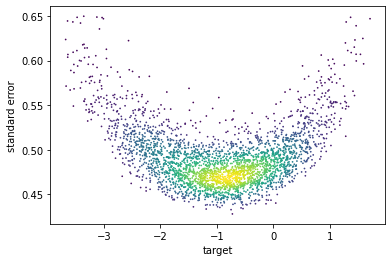

In [16]:
#plt.scatter(train_df['target'],train_df['standard_error'])

x = train_df['target']
y = train_df['standard_error']

# Calculate the point density
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots()
ax.scatter(x, y, c=z, s=0.5)
plt.xlabel('target')
plt.ylabel('standard error')
plt.show()

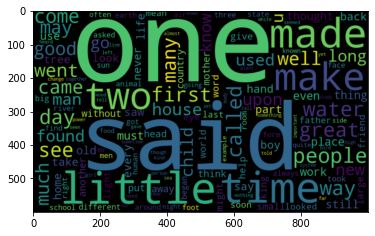

In [17]:
fig = 1

def show_word_cloud(corpus):
    global fig
    wc = WordCloud(stopwords=STOPWORDS, width=1000, height=600, max_words=150)
    wc.generate(' '.join(corpus['normalized']))
    plt.figure(fig)
    fig += 1
    plt.imshow(wc, interpolation='bilinear')
'''
show_word_cloud(train_df[:500])
show_word_cloud(train_df[500:1000])
show_word_cloud(train_df[1000:1500])
show_word_cloud(train_df[1500:2000])
show_word_cloud(train_df[2000:2500])
'''

show_word_cloud(train_df)
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


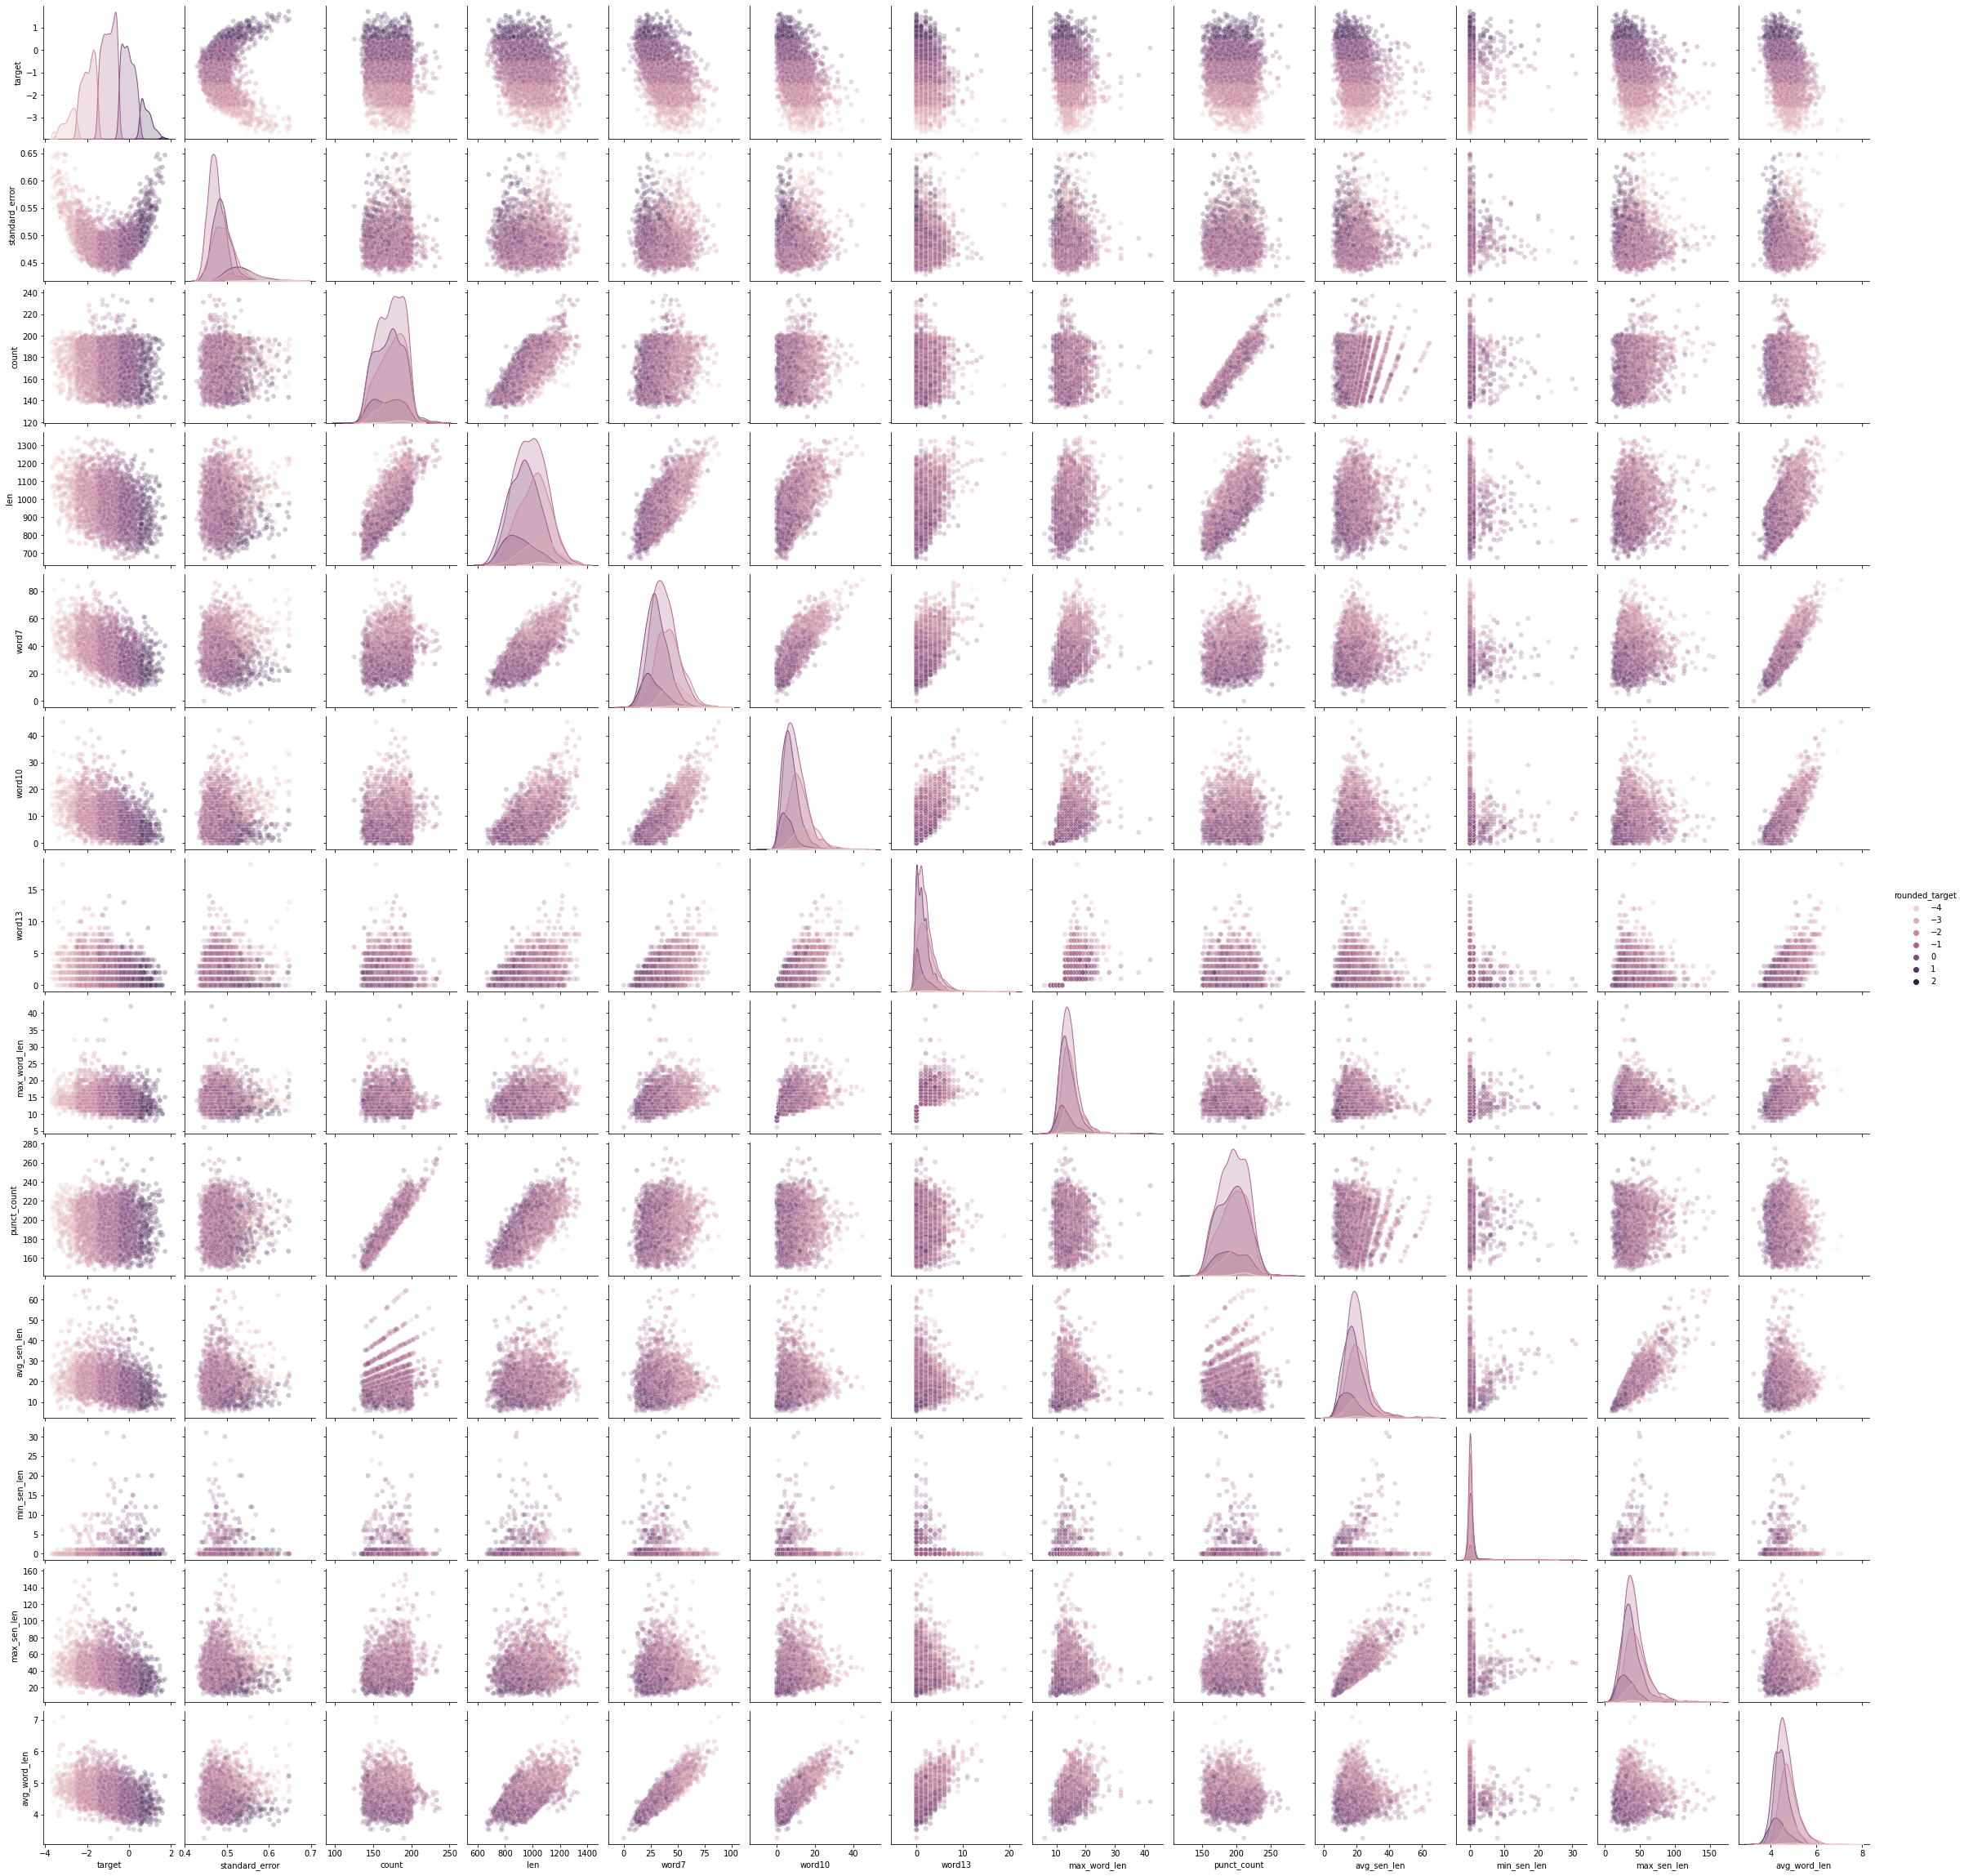

In [18]:
datasScatter = sns.pairplot(train_df, hue = 'rounded_target', plot_kws={'alpha': 0.25}, corner = False, diag_kind="kde", palette = sns.set_palette('bright'))
#datasScatter.map_lower(sns.kdeplot, levels=4, color=".2")
#datasScatter.savefig("Datas_scatter.png", facecolor = 'white')

In [19]:
'''def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

lemmatizer = WordNetLemmatizer()
def clean_text(text):
    text = re.sub('[^A-Za-z0-9]+', ' ', text.lower())
    words = nltk.word_tokenize(text)
    tagged = nltk.pos_tag(words)
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged]
    words = [word for word in words if word not in stopwords.words('english')]
    return words

def get_ngrams(words, n):
    return [tuple(words[i:i+n]) for i in range(len(words)-n+1)]

corpus = []
for text, target in train_df[['excerpt', 'target']].itertuples(index=False):
    sentences = []
    for sentence in tokenize.sent_tokenize(text):
        words = clean_text(sentence)
        unigrams = get_ngrams(words, n=1)
        bigrams = get_ngrams(words, n=2)
        trigrams = get_ngrams(words, n=3)
        sentences.append(words)
    corpus.append({
        'target' : target,
        'text' : text,
        'sentences' : sentences,
        'unigrams' : unigrams,
        'bigrams' : bigrams,
        'trigrams' : trigrams,
    })

corpus = sorted(corpus, key=lambda x: x['target'])



def plot_grams_target(gram_type):
    gram_cnt = defaultdict(lambda: 0)
    gram_sum = defaultdict(lambda: 0.)
    gram_avg = {}

    for datapoint in corpus:
        for gram in datapoint[gram_type]:
            gram_cnt[gram] += 1
            gram_sum[gram] += datapoint['target']

    for gram in gram_cnt:
        if gram_cnt[gram] >= 5:
            gram_avg[gram] = gram_sum[gram] / gram_cnt[gram]
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 8))
    
    top_lowest = sorted(gram_avg.items(), key=lambda x: x[1])[:10]
    ngrams, avg_target = zip(*top_lowest)
    ax[0].bar(
        range(len(ngrams)),
        avg_target
    )

    ax[0].set_title(f'{gram_type} with lowest readability')
    ax[0].set_xlabel(gram_type)
    ax[0].set_ylabel('Average readability')
    ax[0].set_xticks(range(len(ngrams)))
    ax[0].set_xticklabels([' '.join(x) for x in ngrams], rotation='vertical')
    
    top_highest = sorted(gram_avg.items(), key=lambda x: x[1])[-10:]
    ngrams, avg_target = zip(*top_highest)
    ax[1].bar(
        range(len(ngrams)),
        avg_target
    )

    ax[1].set_title(f'{gram_type} with highest readability')
    ax[1].set_xlabel(gram_type)
    ax[1].set_ylabel('Average readability')
    ax[1].set_xticks(range(len(ngrams)))
    ax[1].set_xticklabels([' '.join(x) for x in ngrams], rotation='vertical')

    plt.show()
'''

"def get_wordnet_pos(treebank_tag):\n    if treebank_tag.startswith('J'):\n        return wordnet.ADJ\n    elif treebank_tag.startswith('V'):\n        return wordnet.VERB\n    elif treebank_tag.startswith('N'):\n        return wordnet.NOUN\n    elif treebank_tag.startswith('R'):\n        return wordnet.ADV\n    else:\n        return wordnet.NOUN\n\nlemmatizer = WordNetLemmatizer()\ndef clean_text(text):\n    text = re.sub('[^A-Za-z0-9]+', ' ', text.lower())\n    words = nltk.word_tokenize(text)\n    tagged = nltk.pos_tag(words)\n    words = [lemmatizer.lemmatize(word, get_wordnet_pos(pos)) for word, pos in tagged]\n    words = [word for word in words if word not in stopwords.words('english')]\n    return words\n\ndef get_ngrams(words, n):\n    return [tuple(words[i:i+n]) for i in range(len(words)-n+1)]\n\ncorpus = []\nfor text, target in train_df[['excerpt', 'target']].itertuples(index=False):\n    sentences = []\n    for sentence in tokenize.sent_tokenize(text):\n        words = clean

In [20]:
#plot_grams_target('unigrams')

In [21]:
test_df.head()

id                                    url_legal       license  \
0  c0f722661                                          NaN           NaN   
1  f0953f0a5                                          NaN           NaN   
2  0df072751                                          NaN           NaN   
3  04caf4e0c  https://en.wikipedia.org/wiki/Cell_division  CC BY-SA 3.0   
4  0e63f8bea      https://en.wikipedia.org/wiki/Debugging  CC BY-SA 3.0   

                                             excerpt  
0  My hope lay in Jack's promise that he would ke...  
1  Dotty continued to go to Mrs. Gray's every nig...  
2  It was a bright and cheerful scene that greete...  
3  Cell division is the process by which a parent...  
4  Debugging is the process of finding and resolv...

In [22]:
train_df.describe()

target  standard_error        count          len        word7  \
count  2933.000000     2933.000000  2933.000000  2933.000000  2933.000000   
mean     -0.952244        0.491369   172.543471   976.428571    36.537334   
std       1.026095        0.033299    17.689413   119.352880    12.647589   
min      -3.676268        0.428233   125.000000   669.000000     0.000000   
25%      -1.680656        0.468447   159.000000   889.000000    27.000000   
50%      -0.900441        0.484590   174.000000   976.000000    35.000000   
75%      -0.203188        0.505781   187.000000  1063.000000    45.000000   
max       1.711390        0.649671   237.000000  1341.000000    88.000000   

            word10       word13  max_word_len  punct_count  avg_sen_len  \
count  2933.000000  2933.000000   2933.000000  2933.000000  2933.000000   
mean      9.523355     1.801227     14.288783   195.400273    19.782073   
std       5.960238     1.882199      2.971350    20.518169     7.259249   
min       0.000000     0.000000      6.000000   148.000000     5.285714   
25%       5.000000     0.000000     12.000000   180.000000    15.000000   
50%       9.000000     1.000000     14.000000   196.000000    18.888889   
75%      13.000000     3.000000     16.000000   212.000000    23.428571   
max      45.000000    19.000000     42.000000   275.000000    64.333333   

       min_sen_len  max_sen_len  avg_word_len  rounded_target  
count  2933.000000  2933.000000   2933.000000     2933.000000  
mean      0.445278    41.735424      4.624590       -0.962496  
std       1.973431    17.126950      0.424970        1.060881  
min       0.000000    10.000000      3.257895       -4.000000  
25%       0.000000    30.000000      4.325000       -2.000000  
50%       0.000000    38.000000      4.580838       -1.000000  
75%       0.000000    49.000000      4.872832       -0.000000  
max      31.000000   155.000000      7.090323        2.000000

In [23]:
msno.bar(train_df,color=palette[7], sort="ascending", figsize=(10,5), fontsize=12)
plt.show()

NameError: name 'palette' is not defined

# XGBOOST regressor model

In [24]:
x_train, x_test, y_train, y_test = train_test_split(train_df[training_vars], train_df['target'], test_size=0.1, random_state=42)

In [25]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100, verbosity = 1)

xg_reg.fit(x_train,y_train)

preds = xg_reg.predict(x_test)

rmse = np.sqrt(mse(y_test, preds))
print("RMSE: %f" % (rmse))         #about 0.82

RMSE: 0.807662


In [26]:
xg_reg.fit(train_df[training_vars], train_df['target'])

extract_statistical_feature(test_df)
test_pred = xg_reg.predict(test_df[training_vars])



# Submission file 📝

In [27]:
predictions = pd.DataFrame()
predictions['id'] = test_df['id']
predictions['target'] = test_pred
predictions.to_csv("/kaggle/working/submission.csv", index=False)
predictions

id    target
0  c0f722661 -0.372484
1  f0953f0a5 -0.461912
2  0df072751 -0.744582
3  04caf4e0c -1.823944
4  0e63f8bea -1.845893
5  12537fe78 -0.919458
6  965e592c0 -0.204933